In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
from shapely import wkt
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import re
from scipy.optimize import curve_fit
import random
from collections import defaultdict, deque
import math
from mesa import Model, Agent
from mesa.datacollection import DataCollector
from public_transport_csv_script import remap_ids
from mesa.space import NetworkGrid
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from Queue_model import QueueModel, Cohort

In [2]:
cities = pd.read_csv("data/cities.csv")
lines = pd.read_csv("data/lines.csv")
section_lines = pd.read_csv("data/section_lines.csv")
sections = pd.read_csv("data/sections.csv")
stations = pd.read_csv("data/stations.csv")
station_lines = pd.read_csv("data/station_lines.csv")
transport_modes = pd.read_csv("data/transport_modes.csv")

In [3]:
stations_r = stations.rename(columns={"id": "station_id"})
lines_r    = lines.rename(columns={"id": "line_id"})
modes_r    = transport_modes.rename(columns={"id": "transport_mode_id",
                                           "name": "mode"})
cities_r   = cities.rename(columns={"id": "city_id", "name": "city"})

df_geom = (
    station_lines[["station_id", "line_id", "city_id"]]
      .merge(stations_r[["station_id", "city_id", "name", "geometry", "opening"]],
             on=["station_id", "city_id"], how="inner")
      .merge(lines_r[["line_id", "city_id", "transport_mode_id"]],
             on=["line_id", "city_id"], how="inner")
      .merge(modes_r[["transport_mode_id", "mode"]],
             on="transport_mode_id", how="left")
      .merge(cities_r[["city_id", "city"]], on="city_id", how="left")
      [["station_id", "name", "geometry", "mode", "opening", "city"]]
      .drop_duplicates()
      .sort_values(["city", "station_id"])
      .reset_index(drop=True)
)
df_geom = df_geom[["city", "station_id", "name", "geometry", "mode", "opening"]]


In [4]:
stations_r = stations_r.copy()
mask = stations_r["geometry"].notna()
stations_r["geometry"] = stations_r["geometry"].astype("object")
stations_r.loc[mask, "geometry"] = stations_r.loc[mask, "geometry"].apply(
    lambda g: wkt.loads(g) if isinstance(g, str) else g
)

gdf_stations = gpd.GeoDataFrame(stations_r, geometry="geometry", crs="EPSG:4326")

In [5]:
m = df_geom["geometry"].str.extract(
    r'POINT\s*\(\s*(?P<lon>-?\d+(?:\.\d+)?)\s+(?P<lat>-?\d+(?:\.\d+)?)\s*\)',
    flags=re.I
)

df_geom["latitude"]  = pd.to_numeric(m["lat"], errors="coerce")
df_geom["longitude"] = pd.to_numeric(m["lon"], errors="coerce")

In [6]:
df = (
    df_geom.rename(columns={"station_id": "nodeID",
                       "name": "nodeLabel",
                       "opening": "year"})
      [["city", "nodeID", "nodeLabel", "latitude", "longitude", "mode", "year"]]
)

In [7]:
buc = df[df['city'] == 'Tokyo'].reset_index(drop=True)

In [8]:
buc = buc.merge(
    station_lines[["station_id", "line_id"]],
    how="left",
    left_on="nodeID",
    right_on="station_id"
).drop(columns="station_id")

In [9]:
def _haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0088
    lat1, lon1, lat2, lon2 = map(np.deg2rad, (lat1, lon1, lat2, lon2))
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def build_edges_mst(
    df_line,
    min_stations_for_loop=5,
    min_radius_km=0.5,
    max_radius_coeff_var=0.35,
    min_perim_diam_ratio=1.8,
):

    g = df_line.dropna(subset=["latitude", "longitude"]).copy()
    if len(g) < 2:
        return pd.DataFrame(
            columns=["nodeID_from", "nodeID_to", "line_id", "mode", "year", "dist_km"]
        )

    line_id = g["line_id"].iloc[0]

    lats = g["latitude"].to_numpy()
    lons = g["longitude"].to_numpy()
    ids  = g["nodeID"].astype(int).to_numpy()

    H = nx.Graph()
    for nid, lat, lon, mode, year in zip(
        ids, lats, lons, g["mode"], g["year"]
    ):
        H.add_node(
            int(nid),
            lat=float(lat),
            lon=float(lon),
            mode=mode,
            year=year
        )

    for i in range(len(ids)):
        for j in range(i + 1, len(ids)):
            a, b = int(ids[i]), int(ids[j])
            ra = H.nodes[a]
            rb = H.nodes[b]
            w = _haversine_km(ra["lat"], ra["lon"], rb["lat"], rb["lon"])
            H.add_edge(a, b, weight=w)

    T = nx.minimum_spanning_tree(H, weight="weight")

    center_lat = float(lats.mean())
    center_lon = float(lons.mean())

    radii = np.array([
        _haversine_km(lat, lon, center_lat, center_lon)
        for lat, lon in zip(lats, lons)
    ])
    r_mean = float(radii.mean())
    r_std  = float(radii.std(ddof=0))

    n = len(ids)
    max_dist = 0.0
    for i in range(n):
        for j in range(i + 1, n):
            d = _haversine_km(lats[i], lons[i], lats[j], lons[j])
            if d > max_dist:
                max_dist = d
    diameter_km = max_dist

    perimeter_mst_km = float(sum(d["weight"] for _, _, d in T.edges(data=True)))

    is_loop = False
    if (
        len(g) >= min_stations_for_loop and
        diameter_km > 0 and
        r_mean > 0
    ):
        radius_coeff_var  = r_std / r_mean
        perim_diam_ratio  = perimeter_mst_km / diameter_km

        if (
            r_mean >= min_radius_km and
            radius_coeff_var <= max_radius_coeff_var and
            perim_diam_ratio >= min_perim_diam_ratio
        ):
            is_loop = True

    if is_loop:
        degrees = dict(T.degree())
        leaves = [n for n, d in degrees.items() if d == 1]

        if len(leaves) >= 2:
            best_pair = None
            best_w = float("inf")
            for i in range(len(leaves)):
                for j in range(i + 1, len(leaves)):
                    u = leaves[i]
                    v = leaves[j]
                    ru = H.nodes[u]
                    rv = H.nodes[v]
                    w = _haversine_km(ru["lat"], ru["lon"], rv["lat"], rv["lon"])
                    if w < best_w:
                        best_w = w
                        best_pair = (u, v)

            if best_pair is not None:
                u, v = best_pair
                T.add_edge(u, v, weight=best_w)

    edges = []
    for a, b, d in T.edges(data=True):
        na = H.nodes[a]
        edges.append(
            (int(a), int(b), line_id, na["mode"], na["year"], float(d["weight"]))
        )

    edges_df = pd.DataFrame(
        edges,
        columns=["nodeID_from", "nodeID_to", "line_id", "mode", "year", "dist_km"]
    ).drop_duplicates()

    return edges_df


In [10]:
def make_graph(df_nodes, edges):
    G = nx.Graph()
    for _, r in df_nodes.iterrows():
        G.add_node(
            int(r.nodeID),
            label=r.nodeLabel,
            pos=(float(r.longitude), float(r.latitude)),
            mode = r['mode']
        )
    for _, e in edges.iterrows():
        G.add_edge(
            int(e.nodeID_from),
            int(e.nodeID_to),
            line_id=e.line_id,
            dist_km=e.dist_km,
            mode = e['mode']
        )

    return G

In [62]:
graphs_by_line = {}
G_all = nx.Graph()
edges_all = pd.DataFrame(columns=["nodeID_from","nodeID_to","line_id","mode","year"])
center_lat = buc['latitude'].mean()
center_lon = buc['longitude'].mean()

for line_id, grp in buc.groupby("line_id", dropna=False):
    edges = build_edges_mst(grp)
    G_line = make_graph(grp, edges)
    G_all = nx.compose(G_all, G_line)
    edges_all = pd.concat([edges_all, edges], ignore_index=True)

modes = nx.get_edge_attributes(G_all, "mode").values()
unique_modes = set(modes)
print(unique_modes)
print("Number of unique modes:", len(unique_modes))

{'commuter_rail', 'people_mover', 'default', 'tram', 'heavy_rail', 'light_rail', 'high_speed_rail'}
Number of unique modes: 7


In [57]:
G_all.nodes(data=True)

NodeDataView({3680: {'label': '稲荷町 Inaricho', 'pos': (139.78256891161584, 35.71133904555422), 'mode': 'heavy_rail'}, 3681: {'label': '田原町 Tawaramachi', 'pos': (139.79046520254624, 35.709858847769056), 'mode': 'heavy_rail'}, 3682: {'label': '浅草 Asakusa', 'pos': (139.79775499688083, 35.71076761827913), 'mode': 'heavy_rail'}, 3683: {'label': '上野 Ueno', 'pos': (139.77614714682414, 35.71170503318614), 'mode': 'heavy_rail'}, 3684: {'label': '末広町 Suehirocho', 'pos': (139.77167686395453, 35.70293589727085), 'mode': 'heavy_rail'}, 3686: {'label': '神田 Kanda', 'pos': (139.77066577886103, 35.694270341274084), 'mode': 'heavy_rail'}, 3687: {'label': '三越前 Mitsukoshimae', 'pos': (139.77372175863323, 35.68683565455697), 'mode': 'heavy_rail'}, 3688: {'label': '日本橋 Nihombashi', 'pos': (139.77337720842553, 35.682035642661546), 'mode': 'heavy_rail'}, 3689: {'label': '京橋 Kyobashi', 'pos': (139.77006396503478, 35.676723522726824), 'mode': 'heavy_rail'}, 3690: {'label': '銀座 Ginza', 'pos': (139.76528396501766,

In [58]:
# Find the node ID by searching through all nodes
for node_id, data in G_all.nodes(data=True):
    if data.get('label') == "稲荷町 Inaricho":
        print(f"Found node ID: {node_id}")
        print(G_all.nodes[node_id])
        break

Found node ID: 3680
{'label': '稲荷町 Inaricho', 'pos': (139.78256891161584, 35.71133904555422), 'mode': 'heavy_rail'}


In [63]:
G_all.nodes[3680]

{'label': '稲荷町 Inaricho',
 'pos': (139.78256891161584, 35.71133904555422),
 'mode': 'heavy_rail'}

In [64]:
station_name = "稲荷町 Inaricho"

matching_nodes = [(node_id, data) for node_id, data in G_all.nodes(data=True) 
                  if data.get('label') == station_name]

print(f"Found {len(matching_nodes)} node(s) with name '{station_name}':")
for node_id, data in matching_nodes:
    print(f"  Node ID: {node_id}")
    print(f"  Data: {data}")
    print()

Found 2 node(s) with name '稲荷町 Inaricho':
  Node ID: 3680
  Data: {'label': '稲荷町 Inaricho', 'pos': (139.78256891161584, 35.71133904555422), 'mode': 'heavy_rail'}

  Node ID: 9372
  Data: {'label': '稲荷町 Inaricho', 'pos': (139.7826495117941, 35.711357415879164), 'mode': 'light_rail'}



In [ ]:
line_ids = sorted({d["line_id"] for _,_,d in G_all.edges(data=True)})
cmap = cm.get_cmap('tab20', len(line_ids))
line_to_color = {line_id: cmap(i) for i, line_id in enumerate(line_ids)}


plt.figure(figsize=(14,14))
pos = {n: G_all.nodes[n]["pos"] for n in G_all.nodes}
nx.draw_networkx_nodes(
    G_all, pos,
    node_size=5,
    node_color="black",
)

for line_id in line_ids:
    edges_of_line = [
        (u, v) for u, v, d in G_all.edges(data=True)
        if d["line_id"] == line_id
    ]

    nx.draw_networkx_edges(
        G_all, pos,
        edgelist=edges_of_line,
        width=2,
        edge_color=[line_to_color[line_id]],
        
    )
    #n#x.draw_networkx_labels(
     #   G_all, pos,
       # font_size=8,
       # font_color='black'
    #)
plt.axis("equal")
plt.title("Metro Network Colored by Line")
plt.show()

EdgeDataView([('稲荷町 Inaricho', '上野 Ueno', {'line_id': 324, 'dist_km': 0.58122605030067, 'mode': 'heavy_rail'}), ('稲荷町 Inaricho', '田原町 Tawaramachi', {'line_id': 324, 'dist_km': 0.7316901561696695, 'mode': 'heavy_rail'}), ('稲荷町 Inaricho', 'Shitayajinjamae', {'line_id': 828, 'dist_km': 0.10372219683062127, 'mode': 'light_rail'}), ('稲荷町 Inaricho', 'Matsugaya-itchome', {'line_id': 828, 'dist_km': 0.17562824836139918, 'mode': 'light_rail'}), ('田原町 Tawaramachi', '浅草 Asakusa', {'line_id': 324, 'dist_km': 0.6658930421347228, 'mode': 'heavy_rail'}), ('浅草 Asakusa', '本所吾妻橋 Honjo-Azumabashi', {'line_id': 333, 'dist_km': 0.7194761962208415, 'mode': 'heavy_rail'}), ('浅草 Asakusa', '蔵前 Kuramae', {'line_id': 333, 'dist_km': 0.7973502642696846, 'mode': 'heavy_rail'}), ('浅草 Asakusa', 'Kaminarimon', {'line_id': 828, 'dist_km': 0.12471099495589984, 'mode': 'light_rail'}), ('浅草 Asakusa', 'Azumabashi-itchome', {'line_id': 828, 'dist_km': 0.48240210765437785, 'mode': 'light_rail'}), ('浅草 Asakusa', 'Komagata-ni

In [77]:
def create_multilayer_graph(G, max_dist_km=0.7):

    def get_label(n):
        d = G.nodes[n]
        return d.get("label")

    def get_lonlat(n):
        d = G.nodes[n]
        return d.get("pos")
    
    def get_mode(n):
        d = G.nodes[n]
        return d.get("mode")

    #Make a dictionary mapping (label, mode) to list of nodes
    label_mode_to_nodes = {}
    for n in G.nodes:
        lbl = get_label(n)
        mode = get_mode(n)
        key = (lbl, mode)
        label_mode_to_nodes.setdefault(key, []).append(n)

    #Create multilayer graph H where each node is a (label, mode) pair and edges connect nodes with same label and different modes if they are within max_dist_km
    H = nx.Graph()
    old_to_new = {}
    for (lbl, mode), nodes in label_mode_to_nodes.items():
        if len(nodes) == 1:
            n = nodes[0]
            new_name = (lbl, mode)

            attrs = G.nodes[n].copy()
            attrs["label"] = new_name
            attrs["mode"] = mode
            lon, lat = get_lonlat(n)
            attrs["pos"] = (lon, lat)
            attrs["original_node"] = [n]
            H.add_node(new_name, **attrs)
            old_to_new[n] = new_name
            continue
        
        #Cluster nodes with same label and mode based on distance
        C = nx.Graph()
        for n in nodes:
            C.add_node(n)

        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                a, b = nodes[i], nodes[j]
                lon1, lat1 = get_lonlat(a)
                lon2, lat2 = get_lonlat(b)
                d = _haversine_km(lat1, lon1, lat2, lon2)
                if d <= max_dist_km:
                    C.add_edge(a, b, dist_km=d)
        
        components = list(nx.connected_components(C))
        for idx, comp in enumerate(components):
            comp = list(comp)
            if len(components) == 1:
                new_name = (lbl, mode)
            else:
                new_name = (f"{lbl}_{idx}", mode)
            lons = []
            lats = []
            years = []

            for n in comp:
                lon, lat = get_lonlat(n)
                lons.append(lon)
                lats.append(lat)
                d = G.nodes[n]
                if "year" in d and pd.notna(d["year"]):
                    years.append(d["year"])
                lon_avg = float(np.mean(lons))
                lat_avg = float(np.mean(lats))

                attrs = {}
                attrs.update(G.nodes[comp[0]])
                attrs["label"] = new_name
                attrs["mode"] = mode
                attrs["pos"] = (lon_avg, lat_avg)
                attrs["lon"] = lon_avg
                attrs["lat"] = lat_avg
                attrs["year_min"] = min(years) if years else None
                attrs["orig_nodes"] = comp
                H.add_node(new_name, **attrs)
                for n in comp:
                    old_to_new[n] = new_name

        #Add edges to H based on edges in G
    for u, v, data in G.edges(data=True):
        u_new = old_to_new[u]
        v_new = old_to_new[v]
        if u_new is None or v_new is None:
            continue
        if u_new == v_new:
            continue
        if H.has_edge(u_new, v_new):
            if "line_id" in data:
               if "line_id" in data:
                existing = H[u_new][v_new].get("line_ids", set())
                existing.add(data["line_id"])
                H[u_new][v_new]["line_ids"] = existing
        else:
            H.add_edge(u_new, v_new, **data)

    # Add transfer edges between the same station with different modes
    # (these represent transfer points in the network)
    label_to_mode_nodes = {}
    for node in H.nodes():
        label = node[0]  # station name
        if label not in label_to_mode_nodes:
            label_to_mode_nodes[label] = []
        label_to_mode_nodes[label].append(node)

    for label, mode_nodes in label_to_mode_nodes.items():
        if len(mode_nodes) > 1:
            # Create edges between different modes at the same station
            for i in range(len(mode_nodes)):
                for j in range(i + 1, len(mode_nodes)):
                    node1 = mode_nodes[i]
                    node2 = mode_nodes[j]
                    if not H.has_edge(node1, node2):
                        # Transfer edge with zero distance
                        H.add_edge(node1, node2, 
                                  transfer=True, 
                                  dist_km=0,
                                  edge_type="transfer")

    return H, label_to_mode_nodes


In [82]:
H, label_to_mode_nodes = create_multilayer_graph(G_all, max_dist_km=0.7)

In [81]:
H.edges(data=True)

EdgeDataView([(('稲荷町 Inaricho', 'heavy_rail'), ('上野 Ueno', 'heavy_rail'), {'line_id': 324, 'dist_km': 0.58122605030067, 'mode': 'heavy_rail'}), (('稲荷町 Inaricho', 'heavy_rail'), ('田原町 Tawaramachi', 'heavy_rail'), {'line_id': 324, 'dist_km': 0.7316901561696695, 'mode': 'heavy_rail'}), (('稲荷町 Inaricho', 'heavy_rail'), ('Shitayajinjamae', 'light_rail'), {'line_id': 828, 'dist_km': 0.10372219683062127, 'mode': 'light_rail'}), (('稲荷町 Inaricho', 'heavy_rail'), ('Matsugaya-itchome', 'light_rail'), {'line_id': 828, 'dist_km': 0.17562824836139918, 'mode': 'light_rail'}), (('田原町 Tawaramachi', 'heavy_rail'), ('浅草 Asakusa', 'light_rail'), {'line_id': 324, 'dist_km': 0.6658930421347228, 'mode': 'heavy_rail'}), (('浅草 Asakusa', 'light_rail'), ('本所吾妻橋 Honjo-Azumabashi', 'heavy_rail'), {'line_id': 333, 'dist_km': 0.7194761962208415, 'mode': 'heavy_rail'}), (('浅草 Asakusa', 'light_rail'), ('蔵前 Kuramae', 'heavy_rail'), {'line_id': 333, 'dist_km': 0.7973502642696846, 'mode': 'heavy_rail'}), (('浅草 Asakusa', 

/var/folders/rq/k6q5m5x57ggcclsdrpv0g4j00000gn/T/ipykernel_5379/2793753504.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(line_ids))


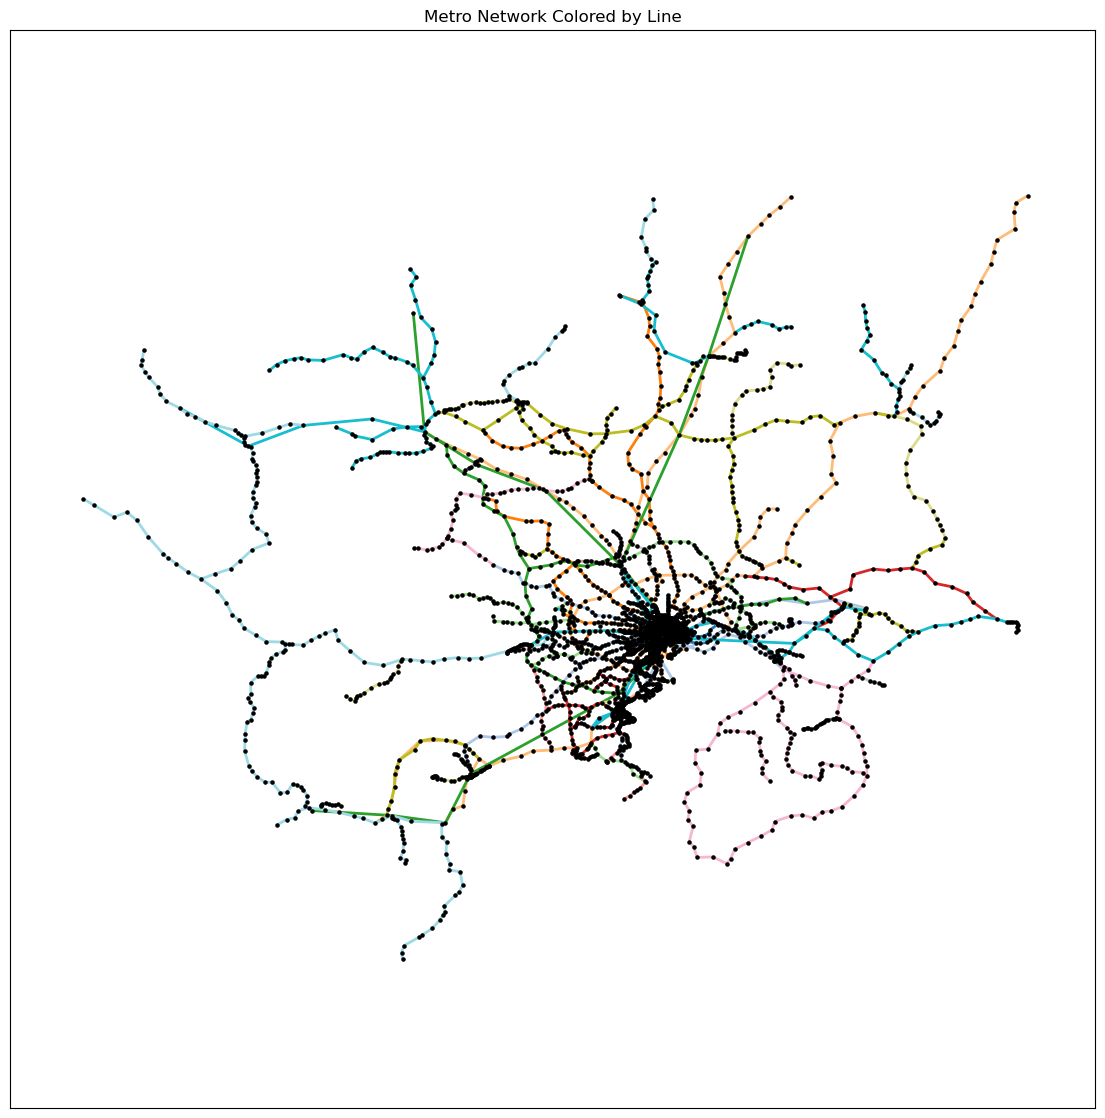

In [84]:
line_ids = sorted({d["line_id"] for _,_,d in H.edges(data=True) if "line_id" in d})
cmap = cm.get_cmap('tab20', len(line_ids))
line_to_color = {line_id: cmap(i) for i, line_id in enumerate(line_ids)}

plt.figure(figsize=(14,14))
pos = {n: H.nodes[n]["pos"] for n in H.nodes}
nx.draw_networkx_nodes(
    H, pos,
    node_size=5,
    node_color="black",
)

for line_id in line_ids:
    edges_of_line = [
        (u, v) for u, v, d in H.edges(data=True)
        if d.get("line_id") == line_id
    ]

    nx.draw_networkx_edges(
        H, pos,
        edgelist=edges_of_line,
        width=2,
        edge_color=[line_to_color[line_id]],
        
    )
    #nx.draw_networkx_labels(
        #H, pos,
        #font_size=8,
        #font_color='black',
    #)

plt.axis("equal")
plt.title("Metro Network Colored by Line")
plt.show()



In [85]:
lcc_nodes = max(nx.connected_components(H), key=len)
G_lcc = G_all.subgraph(lcc_nodes).copy()

In [28]:
destination_nodes = {'浅草 Asakusa':10,
                    '押上 Oshiage (Skytree)':10,
                    '本所吾妻橋 Honjo-Azumabashi':7, 
                    '蔵前 Kuramae':7,
                    '田原町 Tawaramachi':4,
                    '上野 Ueno':4, 
                    'Okachimachi':3,
                    '両国 Ryogoku':3, 
                    '浅草橋 Asakusabashi':3,
                    '南千住 Minami-Senju':2}
destination_nodes_names = list(destination_nodes.keys())

In [31]:
dest_names = np.array(list(destination_nodes.keys()))
w = np.array([destination_nodes[k] for k in dest_names], dtype=float)
dest_prob = w / w.sum()

In [34]:
rng = np.random.default_rng(42)
nodes = np.array(list(G_connect.nodes))
origins = rng.choice(nodes, size=2000)
origin_share = np.ones(len(origins)) / len(origins)   

In [35]:
sum(origin_share)

0.9999999999999453

In [36]:
time_bins  = ["14:00","15:00","16:00","17:00","18:00","19:00"]
time_share = np.array([0.05, 0.10, 0.20, 0.30, 0.25, 0.10], dtype=float)
time_share = time_share / time_share.sum()

In [37]:
# Synthetic arrival distribution based on sensible guesses
def assign_timebins(G,
                    origins,
                    dest_nodes,
                    dest_prob,
                    total_people,
                    time_bins,
                    time_share, #fractions of people arriving by each time bin
                    weight='dist_km'):
    origins = list(origins)
    K = len(origins)
    origin_share = np.ones(K) / K #origin shares quantize what fraction of total people start at each origin
    origin_share = origin_share / origin_share.sum()
    arrivals = {t: defaultdict(float) for t in time_bins} #number of people that arrived at their destination by time t
    origin_paths = {}
    for o in origins:
        _, paths = nx.single_source_dijkstra(G, o, weight=weight)
        origin_paths[o] = paths
    for t, s in zip(time_bins, time_share):
        bin_people = total_people * float(s) #number of people arriving in this time bin
        for o, os in zip(origins, origin_share):
            paths = origin_paths[o]
            for d, dp in zip(dest_nodes, dest_prob):
                f = bin_people * os * dp #number of people from origin o to destination d in this time bin
                arrivals[t][d] += f 
                path = paths.get(d)
                if not path:
                    continue
    return arrivals

arrivals = assign_timebins(G_connect, origins, dest_names, dest_prob, total_people=900_000, time_bins=time_bins, time_share=time_share)

In [38]:
def arrival_schedule_from_bins(arrivals, hotspot, time_bins, tick_seconds=180, bin_seconds=3600):
    ticks_per_bin = int(bin_seconds // tick_seconds)
    sched = {}
    tick0 = 0
    for tb in time_bins:
        people_in_bin = float(arrivals[tb].get(hotspot, 0.0))
        per_tick = people_in_bin / ticks_per_bin
        for k in range(ticks_per_bin):
            sched[tick0 + k] = per_tick 
        tick0 += ticks_per_bin
    return sched
asakusa_schedule = arrival_schedule_from_bins(arrivals, "浅草 Asakusa", time_bins)
oshiage_schedule = arrival_schedule_from_bins(arrivals, "押上 Oshiage (Skytree)", time_bins)
honjo_schedule = arrival_schedule_from_bins(arrivals, "本所吾妻橋 Honjo-Azumabashi", time_bins)
kuramae_schedule = arrival_schedule_from_bins(arrivals, "蔵前 Kuramae", time_bins)
tawaramachi_schedule = arrival_schedule_from_bins(arrivals, "田原町 Tawaramachi", time_bins)
ueno_schedule = arrival_schedule_from_bins(arrivals, "上野 Ueno", time_bins)
oka_schedule = arrival_schedule_from_bins(arrivals, "Okachimachi", time_bins)
ryo_schedule = arrival_schedule_from_bins(arrivals, "両国 Ryogoku", time_bins)
asakusabashi_schedule = arrival_schedule_from_bins(arrivals, "浅草橋 Asakusabashi", time_bins)

In [39]:
schedules = {
    name: arrival_schedule_from_bins(arrivals, name, time_bins)
    for name in destination_nodes_names
}

In [40]:
schedules

{'浅草 Asakusa': {0: 424.52830188678644,
  1: 424.52830188678644,
  2: 424.52830188678644,
  3: 424.52830188678644,
  4: 424.52830188678644,
  5: 424.52830188678644,
  6: 424.52830188678644,
  7: 424.52830188678644,
  8: 424.52830188678644,
  9: 424.52830188678644,
  10: 424.52830188678644,
  11: 424.52830188678644,
  12: 424.52830188678644,
  13: 424.52830188678644,
  14: 424.52830188678644,
  15: 424.52830188678644,
  16: 424.52830188678644,
  17: 424.52830188678644,
  18: 424.52830188678644,
  19: 424.52830188678644,
  20: 849.0566037735729,
  21: 849.0566037735729,
  22: 849.0566037735729,
  23: 849.0566037735729,
  24: 849.0566037735729,
  25: 849.0566037735729,
  26: 849.0566037735729,
  27: 849.0566037735729,
  28: 849.0566037735729,
  29: 849.0566037735729,
  30: 849.0566037735729,
  31: 849.0566037735729,
  32: 849.0566037735729,
  33: 849.0566037735729,
  34: 849.0566037735729,
  35: 849.0566037735729,
  36: 849.0566037735729,
  37: 849.0566037735729,
  38: 849.0566037735729,
 

In [41]:
tick_seconds = 5 * 60
cohort_mass = 170

default_mode_capacity = 700
light_rail_capacity = 450
people_mover_capacity = 170
heavy_rail_capacity = 2000
commuter_rail_capacity = 1000
high_speed_rail_capacity = 800
tram_capacity = 225

default_mode_minutes = 7
light_rail_minutes = 7
people_mover_minutes = 5
heavy_rail_minutes = 15
commuter_rail_minutes = 6
high_speed_rail_minutes = 15
tram_minutes = 8

default_mode_capacity_per_tick = default_mode_capacity / (default_mode_minutes * 60 / tick_seconds)
light_rail_capacity_per_tick = light_rail_capacity / (light_rail_minutes * 60 / tick_seconds)
people_mover_capacity_per_tick = people_mover_capacity / (people_mover_minutes * 60 / tick_seconds)
heavy_rail_capacity_per_tick = heavy_rail_capacity / (heavy_rail_minutes * 60 / tick_seconds)
commuter_rail_capacity_per_tick = commuter_rail_capacity / (commuter_rail_minutes * 60 / tick_seconds)
high_speed_rail_capacity_per_tick = high_speed_rail_capacity / (high_speed_rail_minutes * 60 / tick_seconds)
tram_capacity_per_tick = tram_capacity  / (tram_minutes * 60 / tick_seconds)

In [86]:
for u, v, data in G_lcc.edges(data=True):
    if data.get("mode") == "heavy_rail":
        data["cap_ppl_per_tick"] = heavy_rail_capacity_per_tick
    elif data.get("mode") == "commuter_rail":
        data["cap_ppl_per_tick"] = commuter_rail_capacity_per_tick
    elif data.get("mode") == "light_rail":
        data["cap_ppl_per_tick"] = light_rail_capacity_per_tick
    elif data.get("mode") == "default":
        data["cap_ppl_per_tick"] = default_mode_capacity_per_tick
    elif data.get("mode") == "people_mover":
        data["cap_ppl_per_tick"] = people_mover_capacity_per_tick
    elif data.get("mode") == "light_rail":
        data["cap_ppl_per_tick"] = high_speed_rail_capacity_per_tick
    elif data.get("mode") == "tram":
        data["cap_ppl_per_tick"] = tram_capacity_per_tick

In [87]:
model = QueueModel(
    H=G_lcc,
    entry_nodes=list(G_lcc.nodes),
    dest_nodes=destination_nodes_names,
    schedules=schedules,
    total_target = sum(sum(sched.values()) for sched in list(schedules.values())),
    pos=pos,
    sigma_xy=0.186,
    weight='dist_km',
    tick_seconds=tick_seconds,
    cohort_mass=cohort_mass,
    cap_attr = 'cap_ppl_per_tick',
    seed = 1
)

while model.running:
    model.step()
    

df = model.datacollector.get_model_vars_dataframe()


AxisError: axis 1 is out of bounds for array of dimension 1

In [46]:
G_lcc.nodes["稲荷町 Inaricho"]

{'label': '稲荷町 Inaricho',
 'pos': (139.78260921170497, 35.711348230716695),
 'mode': 'heavy_rail',
 'lon': 139.78260921170497,
 'lat': 35.711348230716695,
 'modes': ['heavy_rail', 'light_rail'],
 'year_min': None,
 'orig_nodes': [3680, 9372]}

In [ ]:
sum(sum(sched.values()) for sched in list(schedules.values())[:-1])

866037.7358490586

In [ ]:
max(df['max_node_queue'])

60534.28571428575

In [ ]:
df = model.datacollector.get_model_vars_dataframe()
print("min tick:", df["tick"].min(), "max tick:", df["tick"].max())
print("tick_seconds:", getattr(model, "tick_seconds", None))


min tick: 0 max tick: 644
tick_seconds: 180


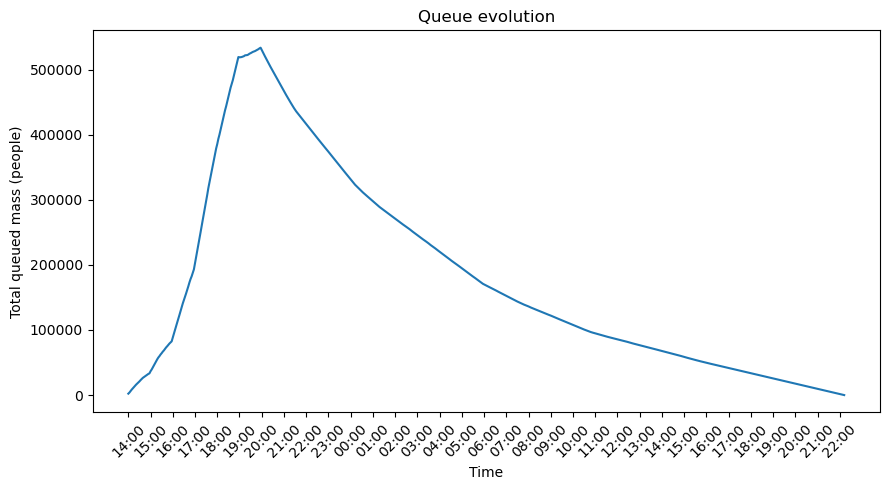

In [ ]:
def tick_to_hhs(tick, start_hour=14):
    total_minutes = start_hour * 60 + tick * model.tick_seconds / 60
    h = int(total_minutes // 60) % 24   
    m = int(total_minutes % 60)
    return f"{h:02d}:{m:02d}"


labels = [tick_to_hhs(t) for t in df["tick"]]

plt.figure(figsize=(9,5))
plt.plot(df["tick"], df["total_queued"])
plt.xticks(df["tick"][::20], labels[::20], rotation=45)
plt.xlabel("Time")
plt.ylabel("Total queued mass (people)")
plt.title("Queue evolution")
plt.tight_layout()
plt.show()


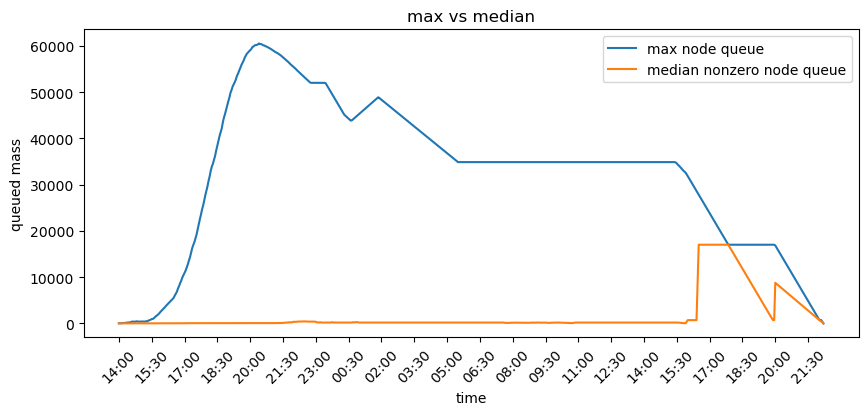

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df["tick"], df["max_node_queue"], label="max node queue")
plt.plot(df["tick"], df["median_nonzero_queue"], label="median nonzero node queue")
plt.xticks(df["tick"][::30], labels[::30], rotation=45)
plt.xlabel("time")
plt.ylabel("queued mass")
plt.legend()
plt.title("max vs median")
plt.show()


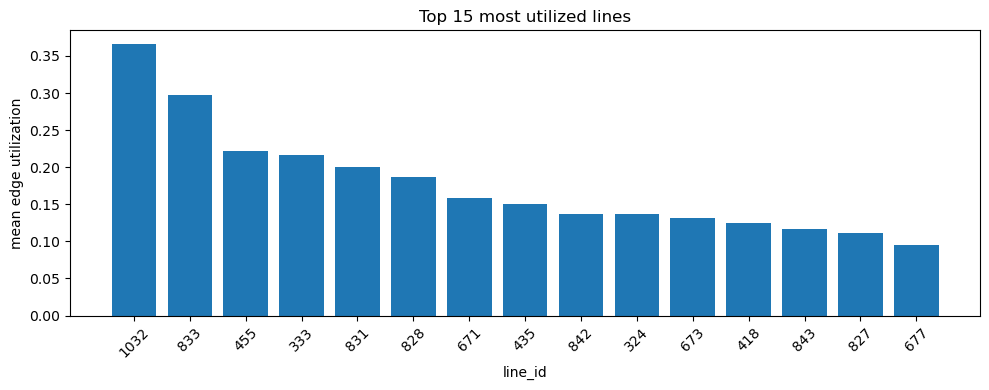

In [ ]:
T = max(len(df), 1)

line_edge_utils = defaultdict(list)

for (u, v), flow in model.edge_flow_sum.items():
    data = model.H.get_edge_data(u, v, default={})
    line_id = data.get("line_id", None)
    if line_id is None:
        continue

    cap = float(data.get(model.cap_attr, np.inf))
    if not np.isfinite(cap) or cap <= 0:
        continue

    ubar_e = float(flow) / (cap * T)
    line_edge_utils[line_id].append(ubar_e)

# mean utilization per line
line_util = {
    line: float(np.mean(utils))
    for line, utils in line_edge_utils.items()
    if len(utils) > 0
}

K = 15
top_lines = sorted(line_util.items(), key=lambda x: x[1], reverse=True)[:K]

line_ids = [str(l) for l, _ in top_lines]
line_vals = np.array([v for _, v in top_lines], dtype=float)

plt.figure(figsize=(10, 4))

plt.bar(line_ids, line_vals)
plt.xlabel("line_id")
plt.ylabel("mean edge utilization")
plt.title("Top 15 most utilized lines")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [ ]:
# node_queue_max[n] = max queue mass ever observed at node n
bottleneck_node, bottleneck_q = max(
    model.node_queue_max.items(),
    key=lambda kv: kv[1]
)

print("Biggest bottleneck station:")
print("Node:", bottleneck_node)
print("Max queued mass:", bottleneck_q)



Biggest bottleneck station:
Node: Shinagawa
Max queued mass: 60534.28571428575


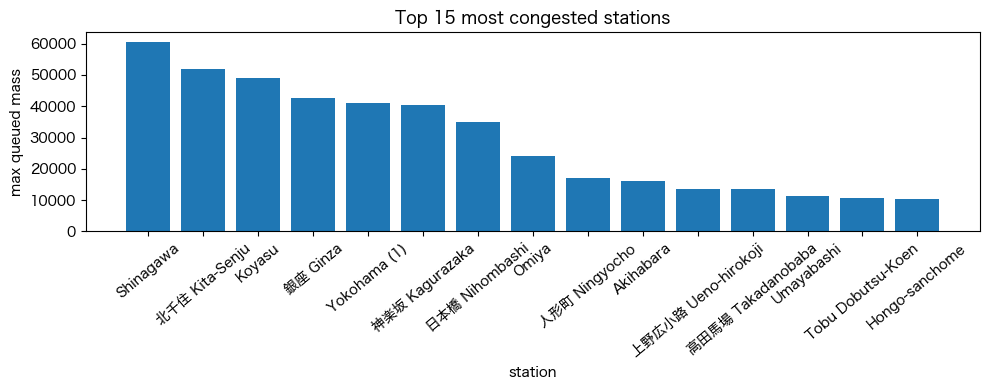

In [ ]:
from matplotlib import font_manager, rcParams

font_path = "/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"  # Hiragino (Japanese)
font_prop = font_manager.FontProperties(fname=font_path)

rcParams["font.family"] = font_prop.get_name()

top_nodes = sorted(
    model.node_queue_max.items(),
    key=lambda kv: kv[1],
    reverse=True
)[:K]

nodes = [str(n) for n, _ in top_nodes]
vals  = np.array([v for _, v in top_nodes], dtype=float)

plt.figure(figsize=(10, 4))

plt.bar(nodes, vals)
plt.xlabel("station")
plt.ylabel("max queued mass")
plt.title("Top 15 most congested stations")
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()


In [ ]:
G_lcc.edges(data=True)

EdgeDataView([('稲荷町 Inaricho', '上野 Ueno', {'line_id': 324, 'dist_km': 0.58122605030067, 'mode': 'heavy_rail', 'cap_ppl_per_tick': 400.0}), ('稲荷町 Inaricho', '田原町 Tawaramachi', {'line_id': 324, 'dist_km': 0.7316901561696695, 'mode': 'heavy_rail', 'cap_ppl_per_tick': 400.0}), ('稲荷町 Inaricho', 'Shitayajinjamae', {'line_id': 828, 'dist_km': 0.10372219683062127, 'mode': 'light_rail', 'cap_ppl_per_tick': 192.85714285714283}), ('稲荷町 Inaricho', 'Matsugaya-itchome', {'line_id': 828, 'dist_km': 0.17562824836139918, 'mode': 'light_rail', 'cap_ppl_per_tick': 192.85714285714283}), ('田原町 Tawaramachi', '浅草 Asakusa', {'line_id': 324, 'dist_km': 0.6658930421347228, 'mode': 'heavy_rail', 'cap_ppl_per_tick': 400.0}), ('浅草 Asakusa', '本所吾妻橋 Honjo-Azumabashi', {'line_id': 333, 'dist_km': 0.7194761962208415, 'mode': 'heavy_rail', 'cap_ppl_per_tick': 400.0}), ('浅草 Asakusa', '蔵前 Kuramae', {'line_id': 333, 'dist_km': 0.7973502642696846, 'mode': 'heavy_rail', 'cap_ppl_per_tick': 400.0}), ('浅草 Asakusa', 'Kaminarim

In [ ]:
df = model.datacollector.get_model_vars_dataframe()

# expand dict column into a DataFrame (ticks x line_id)
L = pd.DataFrame(df["line_queue_mass"].tolist()).fillna(0.0)

top15 = L.mean(axis=0).sort_values(ascending=False).head(15)
top15

324     48787.203488
326     44868.468882
423     44400.790255
333     40069.711628
327     39417.347951
418     29485.922481
3000    29368.316279
641     29365.554374
454     27221.556146
664     25782.128018
417     24350.334468
1032    20207.749723
537     19581.751938
325     19274.980759
534     18388.978959
dtype: float64

In [ ]:
for u, v, data in G_lcc.edges(data=True):
    if data.get("mode") == "heavy_rail":
        data["cap_ppl_per_tick"] = heavy_rail_capacity_per_tick
    elif data.get("mode") == "commuter_rail":
        data["cap_ppl_per_tick"] = commuter_rail_capacity_per_tick
    elif data.get("mode") == "light_rail":
        data["cap_ppl_per_tick"] = light_rail_capacity_per_tick
    elif data.get("mode") == "default":
        data["cap_ppl_per_tick"] = default_mode_capacity_per_tick
    elif data.get("mode") == "people_mover":
        data["cap_ppl_per_tick"] = people_mover_capacity_per_tick
    elif data.get("mode") == "light_rail":
        data["cap_ppl_per_tick"] = high_speed_rail_capacity_per_tick
    elif data.get("mode") == "tram":
        data["cap_ppl_per_tick"] = tram_capacity_per_tick

In [ ]:
lines_at_shinagawa = {
    data["line_id"]
    for u, v, data in G_lcc.edges("新橋 Shimbashi", data=True)
    if "line_id" in data
}

print(lines_at_shinagawa)


{417, 324, 454, 649, 537, 638}


In [ ]:
def k_closest_by_graph_distance(G, source, k, weight=None, include_source=True):
    # shortest path lengths from source
    lengths = nx.single_source_dijkstra_path_length(G, source, weight=weight) if weight else \
              nx.single_source_shortest_path_length(G, source)

    items = sorted(lengths.items(), key=lambda kv: kv[1])  # (node, dist)
    if not include_source:
        items = [(n, d) for n, d in items if n != source]

    chosen = [source] if include_source else []
    chosen += [n for n, _ in items[: max(0, k - len(chosen))]]

    return G.subgraph(chosen).copy(), chosen

In [ ]:
H_k, nodes_k = k_closest_by_graph_distance(G_lcc, "Shinagawa", k=400, weight="dist_km")


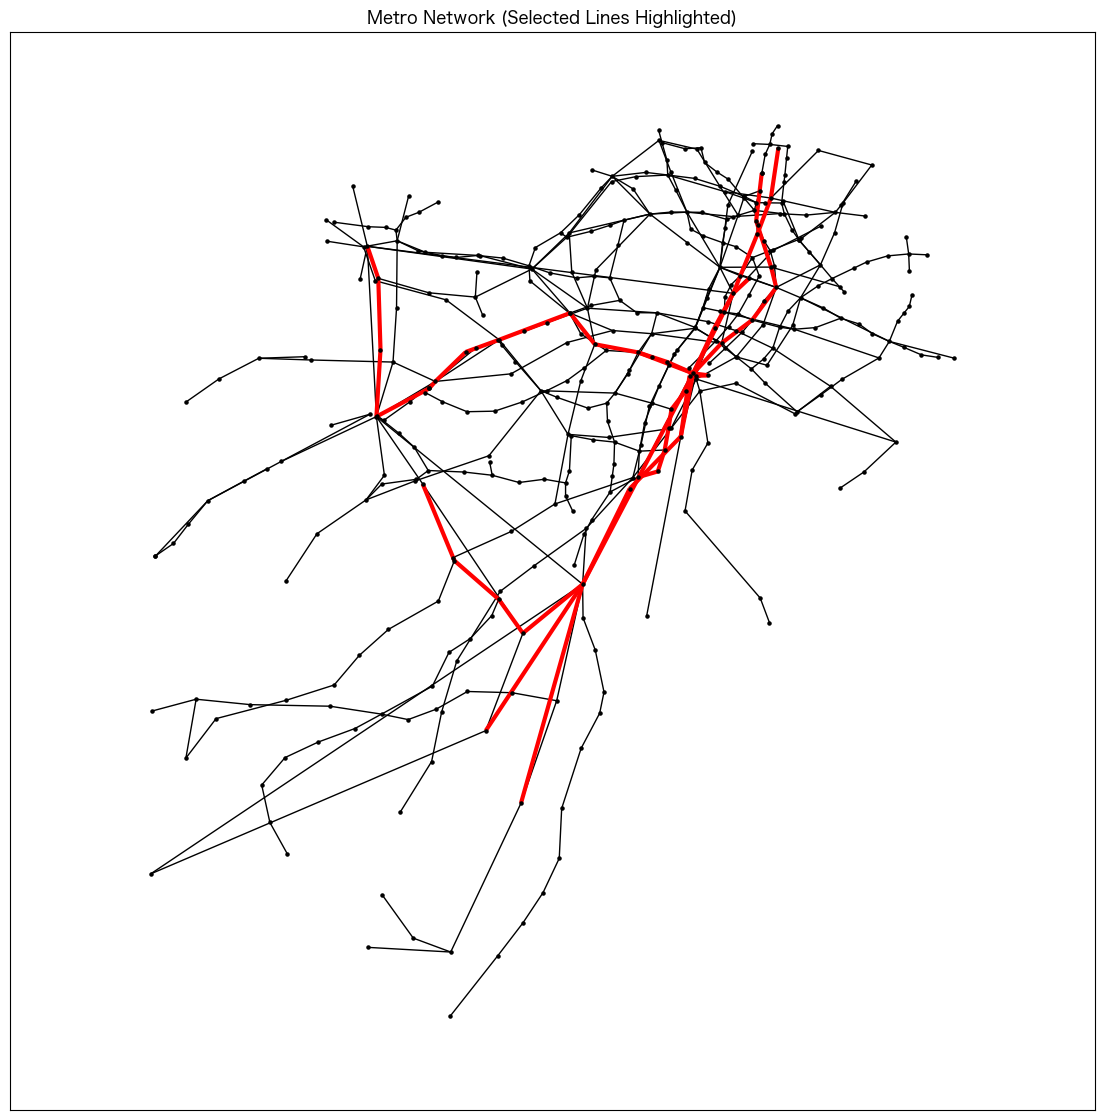

In [ ]:
highlight_lines = lines_at_shinagawa

plt.figure(figsize=(14, 14))
pos = {n: H_k.nodes[n]["pos"] for n in H_k.nodes}

nx.draw_networkx_nodes(
    H_k, pos,
    node_size=5,
    node_color="black",
)

# all edges black
nx.draw_networkx_edges(
    H_k, pos,
    edge_color="black",
    width=1,
)

# overlay highlighted lines
edges_highlight = [
    (u, v) for u, v, d in H_k.edges(data=True)
    if d.get("line_id") in highlight_lines
]

nx.draw_networkx_edges(
    H_k, pos,
    edgelist=edges_highlight,
    edge_color="red",
    width=3,
)

plt.axis("equal")
plt.title("Metro Network (Selected Lines Highlighted)")
plt.show()


In [ ]:
for u, v, data in G_lcc.edges(data=True):
    if data.get("line_id") == 417:
        data["cap_ppl_per_tick"] *= 6
    elif data.get("line_id") == 418:
        data["cap_ppl_per_tick"] *= 4
    elif data.get("line_id") == 454:
        data["cap_ppl_per_tick"] *= 6
    elif data.get("line_id") == 423:
        data["cap_ppl_per_tick"] *= 8
    elif data.get("line_id") == 427:
        data["cap_ppl_per_tick"] *= 4
    elif data.get("line_id") == 3000:
        data["cap_ppl_per_tick"] *= 4
    elif data.get("line_id") == 537:
        data["cap_ppl_per_tick"] *= 6
    elif data.get("line_id") == 1032:
        data["cap_ppl_per_tick"] *= 4
    elif data.get("line_id") == 324:
        data["cap_ppl_per_tick"] *= 4
    elif data.get("line_id") == 649:
        data["cap_ppl_per_tick"] *= 4
    elif data.get("line_id") == 638:
        data["cap_ppl_per_tick"] *= 4
    elif data.get("line_id") == 641:
        data["cap_ppl_per_tick"] *= 2
    elif data.get("line_id") == 627:
        data["cap_ppl_per_tick"] *= 2
    elif data.get("line_id") == 333:
        data["cap_ppl_per_tick"] *= 2
    elif data.get("line_id") == 664:
        data["cap_ppl_per_tick"] *= 2
    elif data.get("line_id") == 328:
        data["cap_ppl_per_tick"] *= 2
    elif data.get("line_id") == 435:
        data["cap_ppl_per_tick"] *= 2
    elif data.get("line_id") == 326:
        data["cap_ppl_per_tick"] *= 2
    elif data.get("line_id") == 493:
        data["cap_ppl_per_tick"] *= 2
    
    
    
    

In [ ]:
caps = [
    d["cap_ppl_per_tick"]
    for u, v, d in G_lcc.edges(data=True)
    if d.get("line_id") == 1032
]
caps

[771.4285714285713,
 771.4285714285713,
 771.4285714285713,
 771.4285714285713,
 771.4285714285713,
 771.4285714285713,
 771.4285714285713,
 771.4285714285713,
 771.4285714285713,
 771.4285714285713,
 771.4285714285713,
 771.4285714285713,
 771.4285714285713]

In [ ]:
model = QueueModel(
    H=G_lcc,
    entry_nodes=list(G_lcc.nodes),
    dest_nodes=destination_nodes_names,
    schedules=schedules,
    total_target = sum(sum(sched.values()) for sched in list(schedules.values())),
    pos=pos,
    sigma_xy=0.186,
    weight='dist_km',
    tick_seconds=180,
    cohort_mass=float(20),
    cap_attr = 'cap_ppl_per_tick',
    seed = 1
)

while model.running:
    model.step()
    

df = model.datacollector.get_model_vars_dataframe()

KeyError: '稲荷町 Inaricho'

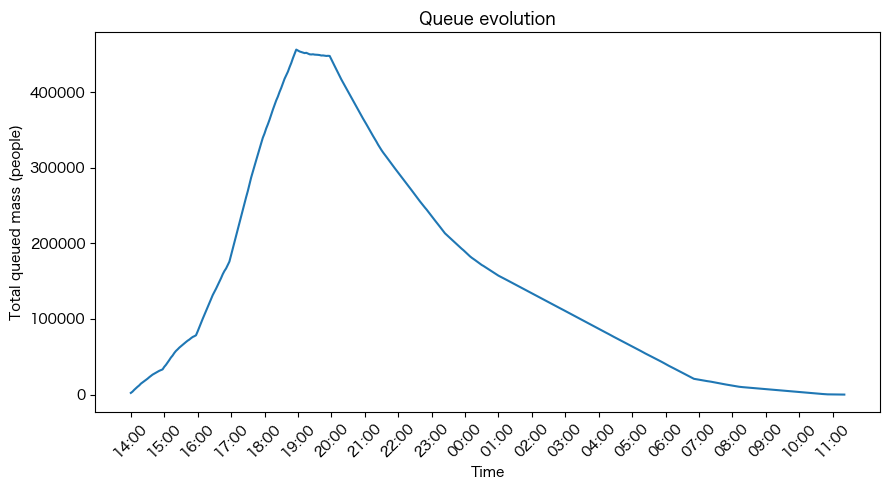

In [ ]:
labels = [tick_to_hhs(t) for t in df["tick"]]

plt.figure(figsize=(9,5))
plt.plot(df["tick"], df["total_queued"])
plt.xticks(df["tick"][::20], labels[::20], rotation=45)
plt.xlabel("Time")
plt.ylabel("Total queued mass (people)")
plt.title("Queue evolution")
plt.tight_layout()
plt.show()


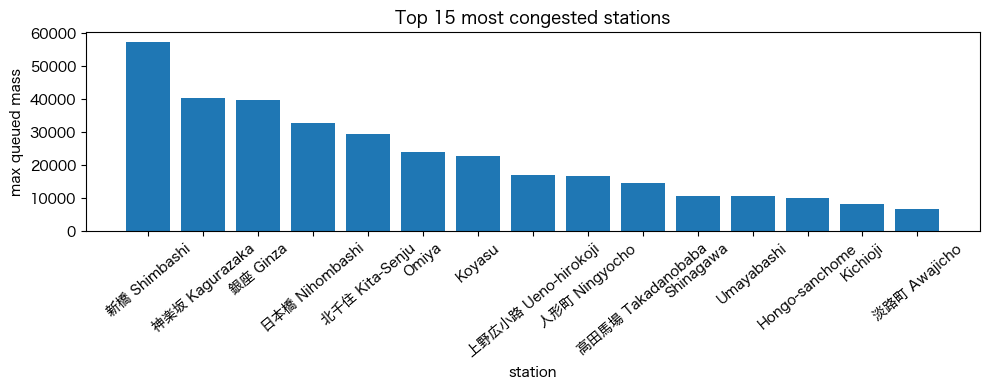

In [ ]:
from matplotlib import font_manager, rcParams

font_path = "/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"  # Hiragino (Japanese)
font_prop = font_manager.FontProperties(fname=font_path)

rcParams["font.family"] = font_prop.get_name()

top_nodes = sorted(
    model.node_queue_max.items(),
    key=lambda kv: kv[1],
    reverse=True
)[:K]

nodes = [str(n) for n, _ in top_nodes]
vals  = np.array([v for _, v in top_nodes], dtype=float)

plt.figure(figsize=(10, 4))

plt.bar(nodes, vals)
plt.xlabel("station")
plt.ylabel("max queued mass")
plt.title("Top 15 most congested stations")
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()